#Data cleaning 

In [3]:
import numpy as np
import pandas as pd 


In [4]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Colab Notebooks/openfoodfacts/'

os.chdir(path)
os.listdir(path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['openfoodfacts.csv']

In [5]:
#because the dataset is too big so chose some data first (80%)
openfoods=pd.read_csv("openfoodfacts.csv",sep='\t',nrows = 2000000)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0,8,14,20,21,22,23,24,28,29,30,32,64,69) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [1]:
total = len(open("openfoodfacts.csv").readlines())
print(total)

FileNotFoundError: ignored

In [6]:
#Check null data : there are lots of categories and many null date in this dataset
openfoods.isnull().sum().sort_values(ascending=True).head(50)

code                                                           0
url                                                            0
created_t                                                      0
created_datetime                                               0
last_modified_t                                                0
last_modified_datetime                                         0
states                                                         0
states_tags                                                    0
states_en                                                      0
completeness                                                   1
creator                                                        4
pnns_groups_2                                               3643
pnns_groups_1                                               3644
ecoscore_grade                                              4205
countries                                                   5432
countries_en             

In [7]:
# we have 2 country categories,the "contries_en" has 4000+ values
openfoods.countries_en.value_counts()

France                                                                              751205
United States                                                                       531377
Germany                                                                             118383
Spain                                                                                94614
United Kingdom                                                                       74534
                                                                                     ...  
Belgium,Francia                                                                          1
Francia,Suiza                                                                            1
French Guiana,Martinique                                                                 1
fr:espagne-🇪🇸,fr:france🇨🇵,fr:portugal🇵🇹                                                  1
Bosnia and Herzegovina,Bulgaria,Croatia,Montenegro,North Macedonia,Poland,Serbia         1

In [8]:
#Check countries ：10000+ values(and some food has 2 and more contries )
openfoods.countries.value_counts().head(50)

France                    395980
United States             309869
en:fr                     234326
en:us                     184722
en:france                  65763
en:es                      56502
en:ca                      55117
en:gb                      41309
en:be                      33351
en:de                      32718
en:it                      31182
España                     27368
en:United States           23671
en:ch                      23607
en:germany                 23375
Deutschland                22855
en:FR                      22766
en:France                  21974
en:Germany                 21441
en:United Kingdom          17533
en:Ireland                 14740
United Kingdom             11058
us                         10599
Germany                     9952
en:ie                       7179
en:BE                       5984
Canada                      5775
Ireland, Germany            5774
fr                          5749
en:Canada                   5634
en:spain  

In [9]:
#because there are lots of categories and missing datas so we just choose some to make data analysis 
nutrition_table = ["product_name","countries","energy_100g","proteins_100g","fat_100g","carbohydrates_100g","sugars_100g","energy-kcal_100g","salt_100g","sodium_100g","categories","fiber_100g","nutrient_levels_tags","ingredients_text"]
new_openfoods = openfoods[nutrition_table].copy()

In [10]:
# drop rows( null and duplicate Values)
new_openfoods = new_openfoods.dropna(axis=0, how='all')
new_openfoods = new_openfoods.drop_duplicates()

In [11]:
#there are too many null values and due to langue issues we choose data of US first
openfoods_us=openfoods[(openfoods['countries']=='United States')|(openfoods['countries']=='en:us')|(openfoods['countries']=='us')|(openfoods['countries']=='en:United States')]

In [12]:
new_openfoods = openfoods_us[nutrition_table].copy()

In [13]:
#product_name is important so drop all null names
new_openfoods = new_openfoods.dropna(axis=0, how='any',subset=['product_name'])

In [14]:
new_openfoods.isnull().sum().sort_values()

product_name                 0
countries                    0
energy_100g              38204
energy-kcal_100g         38251
carbohydrates_100g       39044
fat_100g                 39202
proteins_100g            39315
sugars_100g              48936
salt_100g                67642
sodium_100g              67643
fiber_100g              145094
ingredients_text        203727
categories              225879
nutrient_levels_tags    235239
dtype: int64

In [15]:
len(new_openfoods)

524298

# Ingredients Vectorization

In [16]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import TweetTokenizer
nltk.download('wordnet')
nltk.download('omw-1.4')
lemma=WordNetLemmatizer()
stemm = PorterStemmer()
token = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [17]:
ingredients_us = new_openfoods['ingredients_text']
ingredients_us=ingredients_us.dropna()

In [18]:
ingredients_us.head(10)

9      beta alanine, creatine hcl, ancient peat & app...
64     Bananas, vegetable oil (coconut oil, corn oil ...
65     Peanuts, wheat flour, sugar, rice flour, tapio...
126    Organic hazelnuts, organic cashews, organic wa...
127                                      Organic polenta
128    Rolled oats, grape concentrate, expeller press...
129                        Organic long grain white rice
130    Org oats, org hemp granola (org oats, evaporat...
131    Organic chocolate liquor, organic raw cane sug...
132    Organic expeller pressed, refined high oleic s...
Name: ingredients_text, dtype: object

In [19]:
ingredients_us=list(ingredients_us.values)


In [20]:
len(ingredients_us)

320571

In [21]:
#text cleaning
import re, string 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    if text is None:
        return ''
#remove punctuation and remove words containing numbers,take text lowercase
    text = str(text).replace("nan",'').lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
#tokenizer
    text_token = token.tokenize(text)
#lemaziner
    text_new = []
    for word in text_token :
        if (len(word) >= 1 and word not in STOPWORDS):
            word_lemma = lemma.lemmatize(word)
            word_stem = stemm.stem(word)
            text_new.append(word_stem)

    text_new =list(set(text_new))  

    return text_new    
           
        



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
new_ingredient=[]
for i in range(len(ingredients_us)):
  ingredients_clean=clean_text(ingredients_us[i])
  new_ingredient.append(ingredients_clean)

In [23]:
#Top 20 most frequent words
from collections import defaultdict
word_freq = defaultdict(int)
for word in new_ingredient:
    for i in word:
        word_freq[i] += 1
len(word_freq)

57341

In [24]:
sorted(word_freq, key=word_freq.get, reverse=True)[:20]

['salt',
 'sugar',
 'flavor',
 'water',
 'acid',
 'oil',
 'natur',
 'corn',
 'milk',
 'flour',
 'sodium',
 'citric',
 'syrup',
 'color',
 'wheat',
 'starch',
 'contain',
 'less',
 'soy',
 'gum']

# Modeling

In [25]:
# We use word2vec to make a vocabulary 
from gensim.models import Word2Vec
w2v_model = Word2Vec(min_count=10,window=5, size=200,workers=4)

In [23]:
w2v_model.build_vocab(new_ingredient)

In [24]:
len(w2v_model.wv.vocab)

5648

In [25]:
w2v_model.train(new_ingredient, total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)

<ipython-input-25-e2f946be9c60>:1: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  w2v_model.train(new_ingredient, total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)


(26870322, 38287230)

In [26]:
w2v_model.wv['oil']

array([ 0.07420539,  0.30328935,  1.6104989 , -0.9013457 ,  0.9548778 ,
       -1.4649377 ,  2.2302415 ,  0.22013475,  0.31122196, -1.0646712 ,
        0.59941345, -0.9937718 ,  1.7456152 ,  1.9541984 ,  2.9123783 ,
       -1.8232919 , -0.53334355,  1.9666952 , -1.2179483 , -0.77732044,
        0.9737036 ,  1.7911419 ,  0.89100796, -0.5922229 ,  0.60924643,
       -2.1278894 ,  1.7212286 ,  0.90971094,  1.9409527 ,  0.41573918,
       -0.79492944, -0.13687909,  0.14986476,  0.5783711 , -0.49497625,
       -0.8237448 , -0.9512498 ,  0.5123193 ,  2.1246996 , -1.3596097 ,
        0.39077938, -0.7511288 , -1.4692386 , -0.03911173,  1.6279395 ,
       -0.23584111, -0.05226809, -1.3815465 , -0.782529  ,  1.177004  ,
        0.51500124, -0.02006774,  0.45094588,  0.02393452,  0.703263  ,
        2.418268  , -2.4399612 ,  0.38133535,  0.43526056,  1.4140488 ,
       -1.3886137 , -0.80371076,  0.76745   ,  2.3137908 , -0.88927025,
       -1.0650373 , -1.67348   ,  1.0905858 ,  1.8755215 ,  1.22

In [27]:
#find the most similar words in vocabulary of "oil"
w2v_model.wv.most_similar(positive=['oil'])

[('cornstarch', 0.3338833451271057),
 ('product', 0.3291834592819214),
 ('crouton', 0.3159681558609009),
 ('buttermilk', 0.3150302767753601),
 ('includ', 0.2947615385055542),
 ('potato', 0.2923141121864319),
 ('cauliflow', 0.28253111243247986),
 ('flake', 0.2824838161468506),
 ('herb', 0.27954649925231934),
 ('walnut', 0.27575528621673584)]

In [29]:
#check the similarity of 2 words in vocabulary 
w2v_model.wv.similarity('chip','oil')

0.12528147

In [30]:
#TSNE Map of ingredients
from sklearn.manifold import TSNE
def tsne_plot(model, perplexity=10, n_iter=1000):
    "Create TSNE model and plot it"
    labels = []
    tokens = []

    i = 0
    for word in sorted(model.wv.vocab.keys(), reverse=True):
        tokens.append(model[word])
        labels.append(word)
        i+=1
        if i >= 499:
            break
        
    tsne_model = TSNE(n_components=2, init='pca', random_state=0, perplexity=perplexity, n_iter=n_iter)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    x_min, x_max = np.min(new_values, 0), np.max(new_values, 0)
    X = (new_values - x_min) / (x_max - x_min)
    shown_images = np.array([[1., 1.]])  # just something big
    
    plt.figure(figsize=(20, 20)) 
    for i in range(len(x)):
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        '''if np.min(dist) < 1e-3:
            # don't show points that are too close
            continue'''
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(3, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

<ipython-input-30-fd93869d86dc>:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  tokens.append(model[word])
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9426 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9426 missing from current font.
  font.set_text(s, 0, flags=flags)


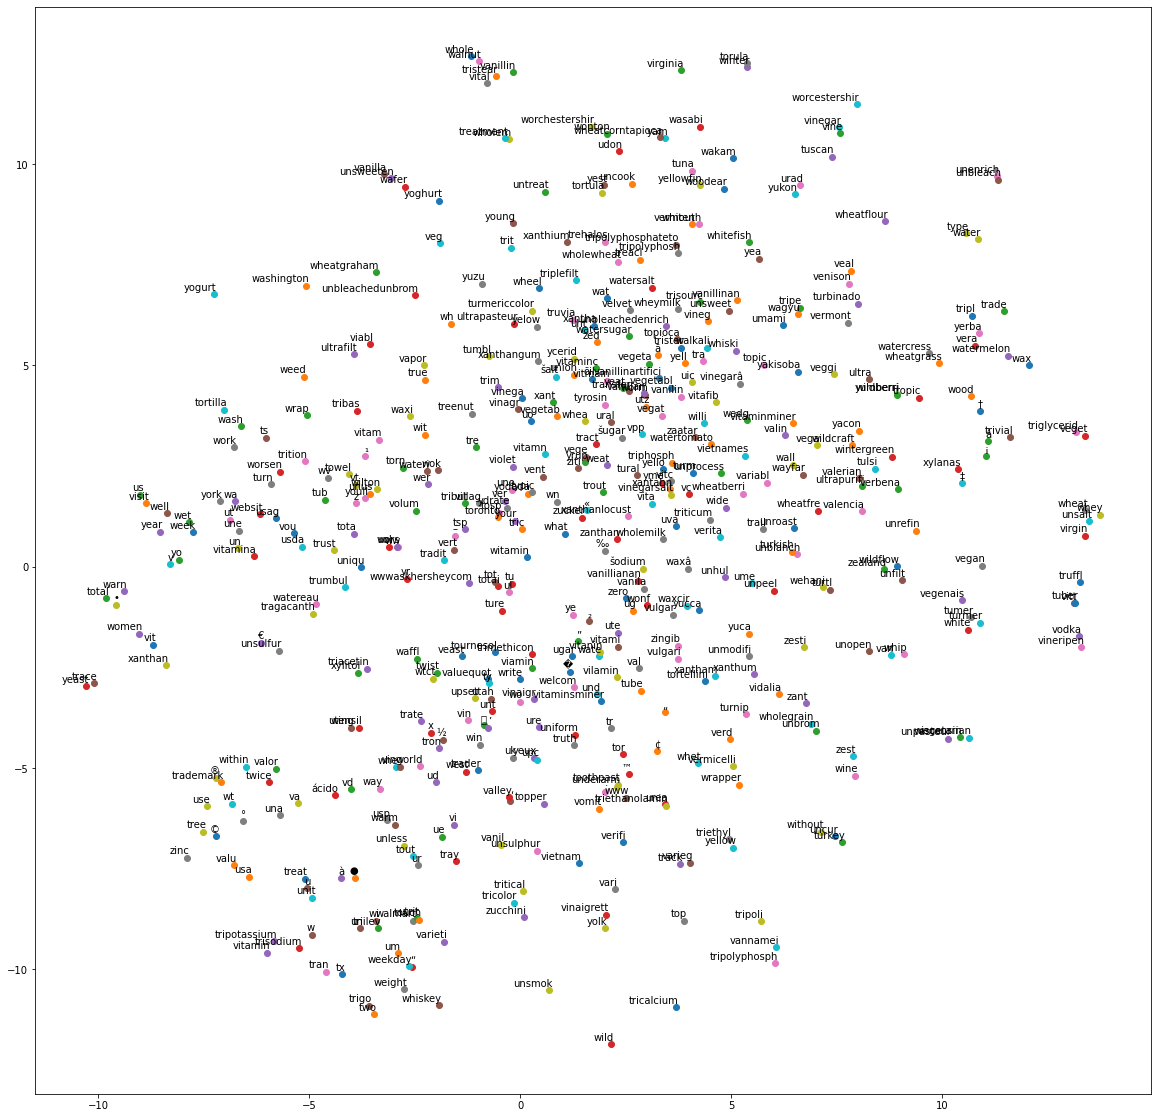

In [31]:

import matplotlib.pyplot as plt
%matplotlib inline
tsne_plot(w2v_model,40,5000)

In [32]:
#find 10 Most similar words and Top 10 Frequent words
from sklearn.decomposition import PCA
import seaborn as sns
sns.set_style("darkgrid")
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 200), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # reduces the dimensionality from 200 to 12 dimensions with PCA
    reduc = PCA(n_components=12).fit_transform(arrays)
    
    # finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


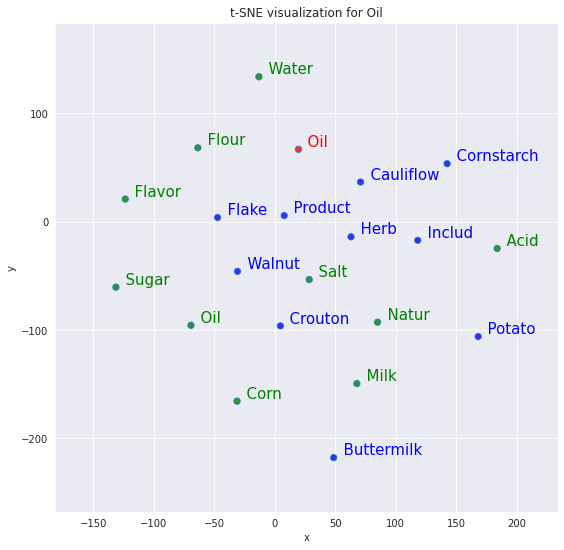

In [33]:
tsnescatterplot(w2v_model, 'oil', sorted(word_freq, key=word_freq.get, reverse=True)[:10])

# Similarly of Products

In [34]:
value =['product_name','ingredients_text']
new_openfoods_us = new_openfoods[value].copy()
new_openfoods_us = new_openfoods_us.dropna(axis=0, how='any',subset=['ingredients_text'])

In [35]:
new_openfoods_us.head(10)

,product_name,ingredients_text
9,hyde icon,"beta alanine, creatine hcl, ancient peat & app..."
64,Banana Chips Sweetened (Whole),"Bananas, vegetable oil (coconut oil, corn oil ..."
65,Peanuts,"Peanuts, wheat flour, sugar, rice flour, tapio..."
126,Organic Salted Nut Mix,"Organic hazelnuts, organic cashews, organic wa..."
127,Organic Polenta,Organic polenta
128,Breadshop Honey Gone Nuts Granola,"Rolled oats, grape concentrate, expeller press..."
129,Organic Long Grain White Rice,Organic long grain white rice
130,Organic Muesli,"Org oats, org hemp granola (org oats, evaporat..."
131,Organic Dark Chocolate Minis,"Organic chocolate liquor, organic raw cane sug..."
132,Organic Sunflower Oil,"Organic expeller pressed, refined high oleic s..."


In [101]:
# find similarity of 2 products 
from numpy import dot
from numpy.linalg import norm
def find_similarity(product1,product2):
    p1 = new_openfoods_us[new_openfoods_us.product_name == product1].index.tolist()
    p2 = new_openfoods_us[new_openfoods_us.product_name == product2].index.tolist()
    p1=p1[0]
    p2=p2[0]
    p_sen1 = clean_text(new_openfoods_us.at[p1,'ingredients_text'])
    p_sen2 = clean_text(new_openfoods_us.at[p2,'ingredients_text'])
    model = w2v_model.wv
    sen_vec1 = np.zeros(200)
    sen_vec2 = np.zeros(200)
    for val in p_sen1:
        sen_vec1 = np.add(sen_vec1, model[val])

    for val in p_sen2:
        sen_vec2 = np.add(sen_vec2, model[val])
    
    return dot(sen_vec1,sen_vec2)/(norm(sen_vec1)*norm(sen_vec2))

In [109]:
# Organic Salted Nut Mix and Organic Sunflower Oil
find_similarity('Peanuts','Peanuts')

1.0

In [139]:
from operator import index

columns1=['product_name','similarity']
index1= new_openfoods_us.index
Product_all = pd.DataFrame(columns=columns1,index=index1)
Product_all['product_name'] = new_openfoods_us['product_name']
Product_all.reset_index(drop=True,inplace=True)

Product_all.head(5)


,product_name,similarity
0,hyde icon,NaN
1,Banana Chips Sweetened (Whole),NaN
2,Peanuts,NaN
3,Organic Salted Nut Mix,NaN
4,Organic Polenta,NaN


In [155]:


for i in range(5000):

     product = Product_all['product_name'][i]
     try:
         Simi  = find_similarity('Organic Salted Nut Mix',product)
         Product_all['similarity'][i] = Simi
     except Exception as e:
            pass
            Simi = -1
          

    #Product_all['similarity'][i] = Simi
    

Product_all.head(10).sort_values(by='similarity',axis=0,ascending=False)

<ipython-input-101-6a38b95efca2>:20: RuntimeWarning: invalid value encountered in double_scalars
  return dot(sen_vec1,sen_vec2)/(norm(sen_vec1)*norm(sen_vec2))


,product_name,similarity
3,Organic Salted Nut Mix,1.0
7,Organic Muesli,0.76971
5,Breadshop Honey Gone Nuts Granola,0.710573
9,Organic Sunflower Oil,0.694597
8,Organic Dark Chocolate Minis,0.565701
1,Banana Chips Sweetened (Whole),0.340841
6,Organic Long Grain White Rice,0.313855
2,Peanuts,0.192369
0,hyde icon,NaN
4,Organic Polenta,NaN


# K-means

In [72]:
#get the embeddings into a matrix
embedding_size=200
embeddings = np.zeros((len(w2v_model.wv.index2word), embedding_size))
for i in range(0, len(w2v_model.wv.index2word)):
    w = w2v_model.wv.index2word[i]
    embeddings[i] = w2v_model.wv[w]

In [74]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2, algorithm='randomized', n_iter=500, random_state=101)
embeddings_2d_projection = svd.fit_transform(embeddings)

In [82]:
#clustering
from sklearn.cluster import KMeans
clusters = 6
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(embeddings)


In [83]:
from scipy.spatial.distance import cdist
centroid_embedding_nearest_words = []
for centroid_embedding in kmeans.cluster_centers_:
    centroid_embedding_nearest_words.append(
        np.argsort([i[0] for i in cdist(embeddings, np.array([centroid_embedding]), "euclidean")])[0:10]
    )

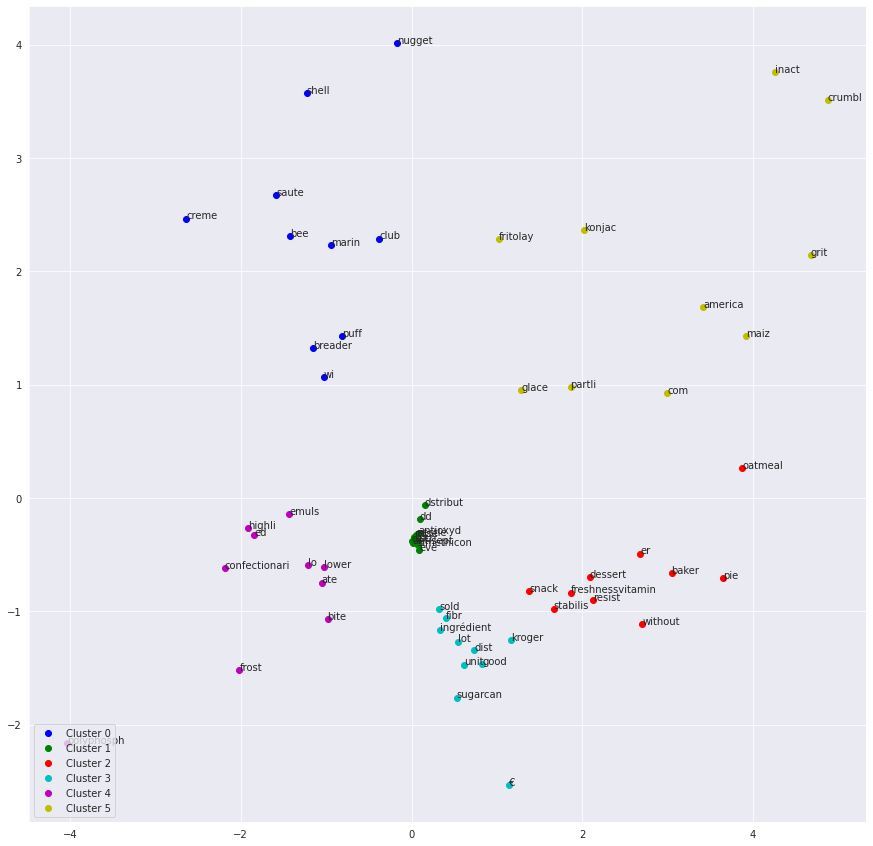

In [85]:
import re, itertools, random
plt.figure(figsize=(15,15))
colors = itertools.cycle(["b","g","r","c","m","y","k","w"])
c = 0
for word_indices in centroid_embedding_nearest_words:
    clr = next(colors)
    plt.scatter(
        embeddings_2d_projection[word_indices,0],
        embeddings_2d_projection[word_indices,1],
        color=clr,
        label="Cluster " + str(c)
    )
    for ix in word_indices:
        x, y = embeddings_2d_projection[ix,:]
        plt.annotate(w2v_model.wv.index2word[ix], (x, y))
    c+=1
plt.legend(loc='lower left')
plt.show()